# Mentions graph analisys

In [87]:
import pandas as pd
import networkx as nx
import numpy as np
import time
import pickle
import re
import matplotlib.pyplot as plt

from networkx.algorithms.community import greedy_modularity_communities, louvain_communities, modularity
from collections import Counter

## Loading data

In [88]:
tweets = pd.read_csv(f'./data/WorldCup/tweets.csv')
users = pd.read_csv(f'./data/WorldCup/users.csv')

In [89]:
# removing tweets without mentions
tweets.dropna(inplace=True)

## Mention to graph extraction

In [90]:
mentions_df_raw = tweets[['author_id', 'mentions']]

In [22]:
mentions_df = mentions_df_raw[~mentions_df_raw.author_id.isin(bot_users.id)]

### Useful functions

In [23]:
# dealing with how the values in the 'mentions' column are saved
def list_capture(input_str: str):
    input_str = input_str[1:-1]
    just_commas = re.sub('\'', '', input_str)
    str_list = just_commas.split(',')
    
    output_list = []
    for ele in str_list:
        output_list.append(int(ele))

    return output_list

In [83]:
def plot_graph(graph, color_list, filename=None, color_labels={}, edge_color=None, alpha_edges=0.6, alpha_nodes=0.6, node_size=None):
    fig = plt.figure(1, figsize=(10,10))
    
    if type(graph) == nx.classes.digraph.DiGraph: 
        if node_size is None:
            node_size = 50
            
        layout=nx.kamada_kawai_layout(graph)
    else:
        if node_size is None:
            node_size = 10
            
        layout=nx.spring_layout(graph)  
        
    
    # good visibilty aspect
    if len(set(color_list)) > 2:
        colormap=plt.cm.gist_rainbow
    else:
        colormap=plt.cm.copper
    
    if edge_color is None:
        edge_color=plt.cm.Greys(0.2)
        
        
    # some magic to add legend
    ax = fig.add_subplot(1,1,1)
    for label, color in color_labels.items():
        ax.scatter([0], [0],
               color=colormap(color),
               label=label,
               alpha=alpha_nodes)
    
    nx.draw_networkx_nodes(graph, pos=layout, node_size=node_size, node_color=color_list, vmax=1.0, alpha=alpha_nodes, cmap=colormap, ax=ax)
    nx.draw_networkx_edges(graph, pos=layout, edge_color=edge_color, ax=ax, alpha=alpha_edges)
    
    # saving to file
    if filename is not None:
        plt.savefig('./graphs/' + filename)
    

    plt.legend()
    ax.axis('off')
    
    plt.show()

In [110]:
# funtion to use its result futher in graph ploting
# for each node gives a number which will represent color
def get_colors_for_communities(communities, graph):
    color_dict = {}

    color = 0.0
    for community in communities:
        for node in community:
            color_dict[node] = color
        color += 1/len(communities)
        
    color_list = []

    for node in graph.nodes():
        color_list.append(color_dict[node])
        
    return color_list

## Directed graphs

### With BOTs

In [92]:
directed_graph_bots = nx.DiGraph()

In [93]:
# building the directed graph
for _, row in mentions_df_raw.iterrows():
    mention_ids = list_capture(row['mentions'])
    
    for mention_id in mention_ids:
        directed_graph_bots.add_edge(row['author_id'], mention_id)

In [95]:
# removing the small compoments
for component in list(nx.weakly_connected_components(directed_graph_bots)):
    if len(component) < 1000:
        for node in component:
            directed_graph_bots.remove_node(node)

In [97]:
# deleting nodes with low degree (below 5)
dir_low_degree_nodes = [node for node,degree in dict(directed_graph_bots.degree()).items() if degree <= 5]
directed_graph_bots.remove_nodes_from(dir_low_degree_nodes)

In [98]:
# after removal another component cleaning
for component in list(nx.weakly_connected_components(directed_graph_bots)):
    if len(component) < 15:
        for node in component:
            directed_graph_bots.remove_node(node)

In [99]:
# removing selfloop egdes
directed_graph_bots.remove_edges_from(nx.selfloop_edges(directed_graph_bots))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


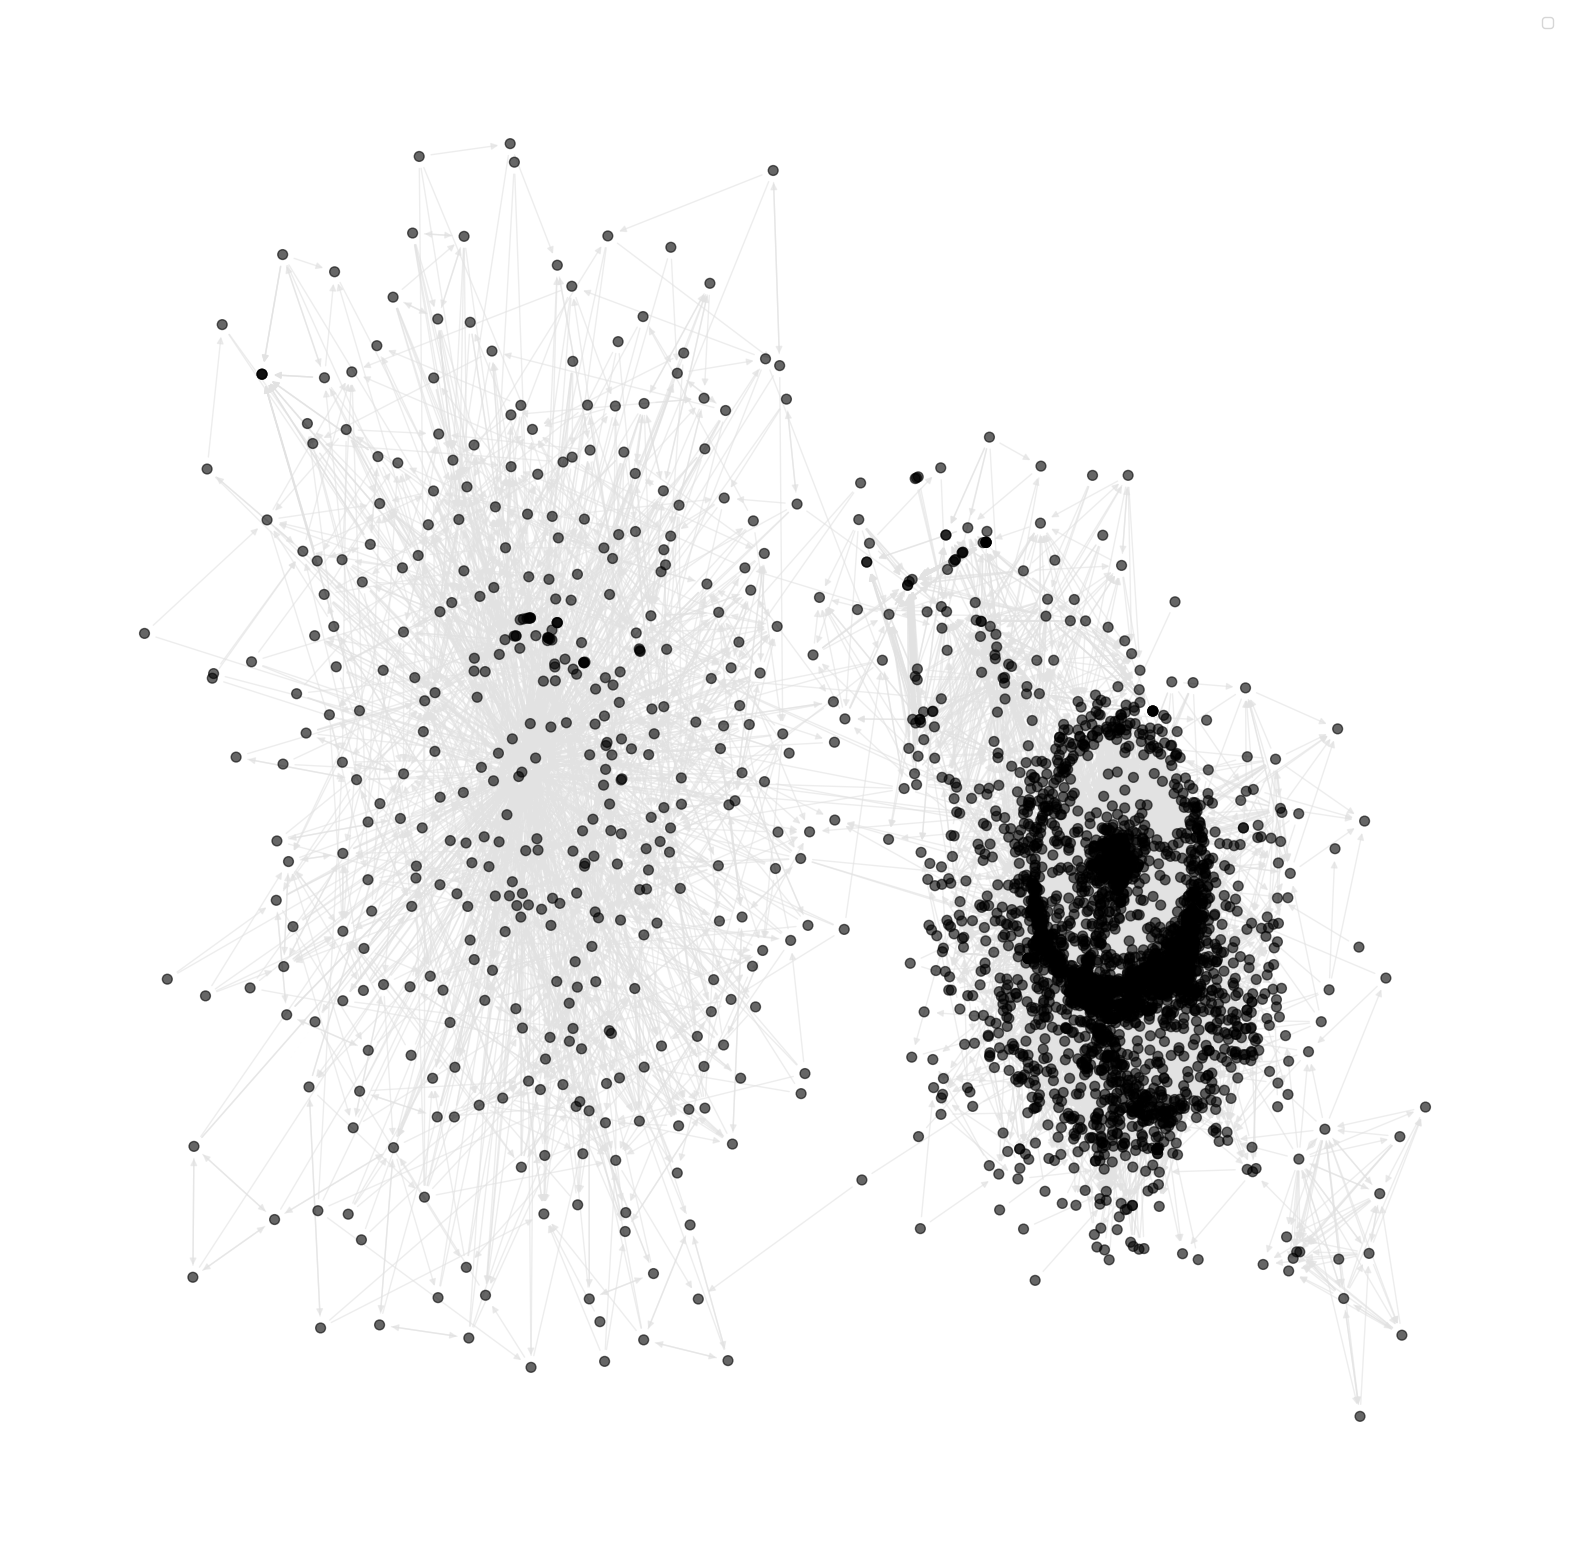

In [67]:
plot_graph(directed_graph_bots, np.ones(len(directed_graph_bots.nodes)))

## Community detection

In [169]:
# detecting communities
c = greedy_modularity_communities(directed_graph_bots, resolution=0.04)

In [170]:
len(c)

4

In [104]:
modularity(directed_graph_bots, c)

0.3140204115544244

In [76]:
dir_mention_colors = get_colors_for_communities(c, directed_graph_bots)

In [62]:
# getting most frequently mentioned users
most_mentioned_for_community = {}

for community_number, community in enumerate(c):
    degrees_in = dir_mentions_graph_bots.in_degree(community)
    
    max_degree = 1
    
    for node, degree in degrees_in:
        if degree > max_degree:
            max_degree = degree
            higest_degree_node = node
            
    most_mentioned_for_community[community_number] = higest_degree_node

In [68]:
users[users.id.isin(most_mentioned_for_community.values())]

id         username                 created_at  \
15               138372303     FIFAWorldCup  2010-04-29 10:58:07+00:00   
22957  1553382185301843974  CryptoSportsHub  2022-07-30 14:09:20+00:00   
25634   794896953314131969      a23_fantasy  2016-11-05 13:39:36+00:00   
75602  1539887116792250369          M3taCup  2022-06-23 08:25:00+00:00   

       followers_count  following_count  tweet_count  protected  verified  
15            10058244              589        29572      False      True  
22957              775               28          306      False     False  
25634             4753              212         4261      False     False  
75602              112                3           12      False     False

In [69]:
most_often_mentioning_for_community = {}

for community_number, community in enumerate(c):
    degrees_out = dir_mentions_graph_bots.out_degree(community)
    
    max_degree = 1
    
    for node, degree in degrees_out:
        if degree > max_degree:
            max_degree = degree
            higest_degree_node = node
            
    most_often_mentioning_for_community[community_number] = higest_degree_node

In [71]:
users[users.id.isin(most_often_mentioning_for_community.values())]

id         username                 created_at  \
2495   1529000363159740417     SmartAnand07  2022-05-24 07:28:10+00:00   
3737             163892413         dejiplus  2010-07-07 14:49:54+00:00   
24474            524510306      timoscholar  2012-03-14 16:36:10+00:00   
75738  1392606838609354758  YvesRol99732549  2021-05-12 22:25:39+00:00   

       followers_count  following_count  tweet_count  protected  verified  
2495               559             2892        19304      False     False  
3737               493               16       252207      False     False  
24474              443             2497         7787      False     False  
75738                9              146          149      False     False

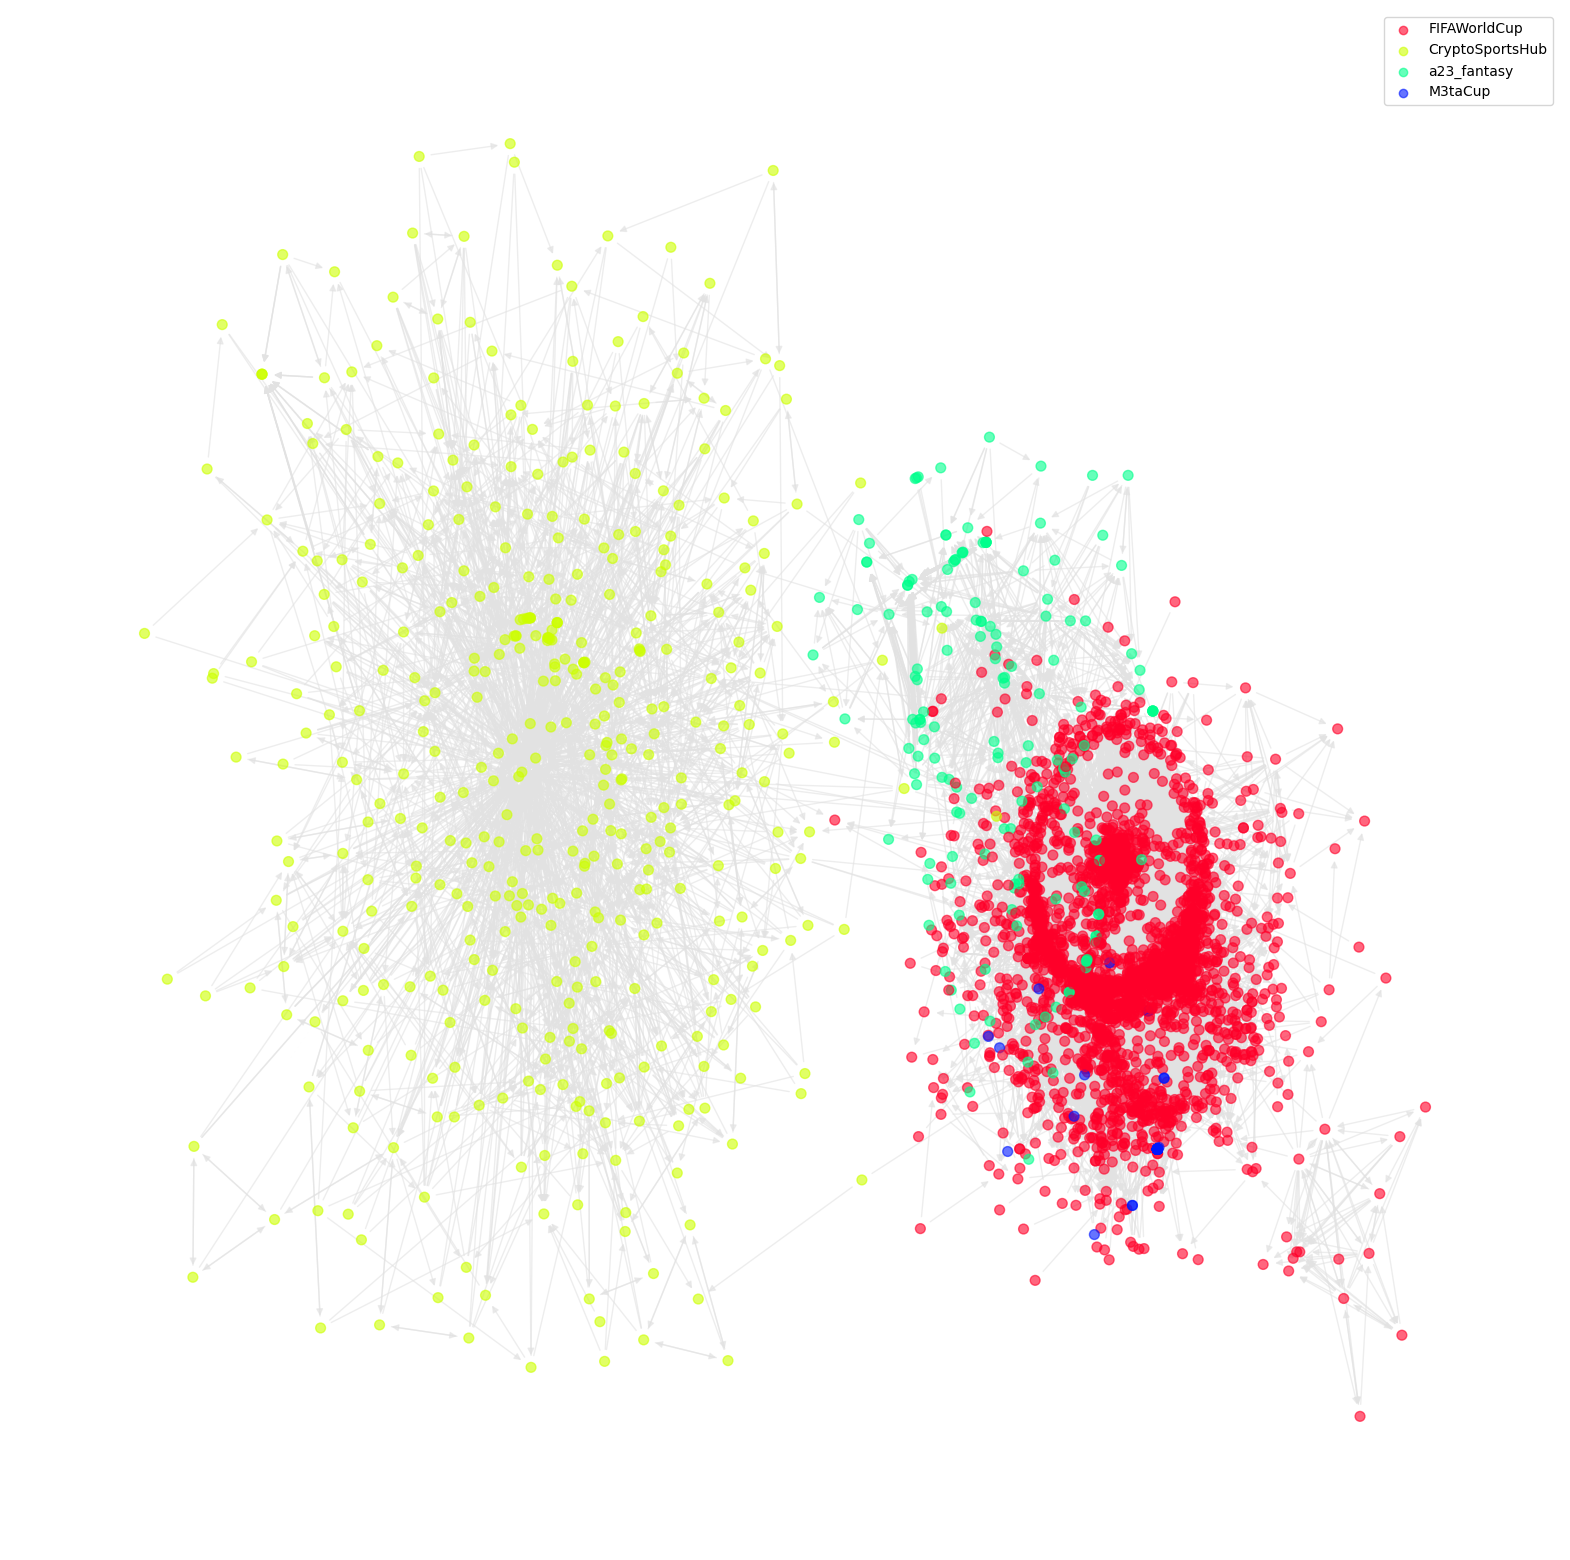

In [212]:
plot_graph(directed_graph_bots, dir_mention_colors, filename='directed-with-bots-spring.png', 
           color_labels={'FIFAWorldCup': 0.0, 'CryptoSportsHub': 0.25, 'a23_fantasy': 0.5, 'M3taCup': 0.75})

## Saving community detection results

In [ ]:
node_to_community = {}

for community_number, community in enumerate(c):
    for node in community:
        node_to_community[node] = community_number

In [222]:
users_used_in_graph = users[users.id.isin(dir_mentions_graph_bots.nodes)]

In [223]:
community_column = users_used_in_graph.id.apply(lambda user_id: node_to_community[user_id])

In [224]:
users_used_in_graph['community_number'] = community_column

C:\Users\jjasi\AppData\Local\Temp\ipykernel_9952\3210924098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_used_in_graph['community_number'] = community_column


In [243]:
users_used_in_graph.to_csv('users-with-communities.csv', index=False)

## Analising detected communities

### Centrality

#### For each community

In [153]:
# getting nodes with highest centrality for each community
community_centrality = {}

for community_number, community in enumerate(c):
    community_subgraph = dir_mentions_graph_bots.subgraph(community)
    
    closeness_cent = nx.closeness_centrality(community_subgraph)
    closeness_cent_sorted = dict(sorted(closeness_cent.items(), key=lambda item: item[1]))
    top_5_closeness_cent= list(closeness_cent_sorted.keys())[:5]
    community_centrality[community_number] = top_5_closeness_cent

In [105]:
def users_and_tweets_of_community(community_number: int):
    return (users[users.id.isin(community_centrality[community_number])], 
            tweets[tweets.author_id.isin(community_centrality[community_number])])

In [154]:
com_top_centrality = [users_and_tweets_of_community(i) for i in range(4)]

#### Red community

In [155]:
com_top_centrality[0][0]

id     username                 created_at  \
8             230186918    alam_Newz  2010-12-24 14:51:40+00:00   
25            745524289  alekhbariyh  2012-08-08 16:37:23+00:00   
32  1219851875408846848   SCUD_PREES  2020-01-22 05:19:08+00:00   
35            266652243      alafqkw  2011-03-15 15:40:05+00:00   
47           4641084214  WAMADA_NEWS  2015-12-29 08:06:36+00:00   

    followers_count  following_count  tweet_count  protected  verified  
8              5117             4018        28124      False     False  
25             6518             4416        57850      False     False  
32              606             1546         3187      False     False  
35            17280               11        12509      False     False  
47             2554             1696        14441      False     False

In [156]:
com_top_centrality[0][1]

hashtag                   id            author_id  \
12  #Qatar2022  1592601122879197185            230186918   
18  #Qatar2022  1592601049428549632            745524289   
25  #Qatar2022  1592600987180888064  1219851875408846848   
28  #Qatar2022  1592600911209435136            266652243   
38  #Qatar2022  1592600846038339584           4641084214   

                                                 text  like_count  \
12  سعادة أ. د.#خالد_بن_إبراهيم_السليطي مدير عام #...           0   
18  سعادة أ. د.#خالد_بن_إبراهيم_السليطي مدير عام #...           0   
25  سعادة أ. د.#خالد_بن_إبراهيم_السليطي مدير عام #...           0   
28  سعادة أ. د.#خالد_بن_إبراهيم_السليطي مدير عام #...           0   
38  سعادة أ. د.#خالد_بن_إبراهيم_السليطي مدير عام #...           0   

    reply_count  retweet_count  quote_count                 created_at lang  \
12            0              0            0  2022-11-15 19:31:11+00:00   ar   
18            0              0            0  2022-11-15 19:30:53+00:00   ar   
25            0              0            0  2022-11-15 19:30:39+00:00   ar   
28            0              0            0  2022-11-15 19:30:20+00:00   ar   
38            0              0            0  2022-11-15 19:30:05+00:00   ar   

                                             mentions  
12  ['2429620166', '353032173', '70427554264881971...  
18  ['2429620166', '353032173', '70427554264881971...  
25  ['2429620166', '353032173', '70427554264881971...  
28  ['2429620166', '353032173', '70427554264881971...  
38  ['2429620166', '353032173', '70427554264881971...

#### Yellow community

In [157]:
com_top_centrality[1][0]

id         username                 created_at  \
1623   1271828392430702594  PrakCryptoholic  2020-06-13 15:35:17+00:00   
27608  1331044355516239872       Sunny34212  2020-11-24 01:18:11+00:00   
34331  1594199257720016897      Ayanokoji75  2022-11-20 05:21:46+00:00   
35032  1253642676886331392        PAVAN_BN_  2020-04-24 11:11:35+00:00   
99349  1574595611739168768   varshamewada13  2022-09-27 03:04:02+00:00   

       followers_count  following_count  tweet_count  protected  verified  
1623               182              755        23157      False     False  
27608               45              428         4518      False     False  
34331                7               50           28      False     False  
35032               60              318        13659      False     False  
99349                3               29           34      False     False

In [168]:
com_top_centrality[1][1].head()

hashtag                   id            author_id  \
1303   #QatarWorldCup2022  1594634991795044352  1271828392430702594   
35413  #QatarWorldCup2022  1596017451531395072  1271828392430702594   
37482  #QatarWorldCup2022  1595904449473830912  1331044355516239872   
53814  #QatarWorldCup2022  1595803740724166656  1594199257720016897   
57413  #QatarWorldCup2022  1595784683304153088  1253642676886331392   

                                                    text  like_count  \
1303   @TheApiens Wow that's amazing opportunity for ...           0   
35413  @May7ven Wow that's amazing opportunity for al...           0   
37482  @a23_fantasy Ans.(D) PELE \n#ChaloSaathKhelein...           0   
53814  @a23_fantasy D. pele\n#ChaloSathKhelein\n#A23 ...           0   
57413  D) Pèle \n#ChaloSaathKhelein\n#QatarWorldCup20...           0   

       reply_count  retweet_count  quote_count                 created_at  \
1303             0              0            0  2022-11-21 10:13:03+00:00   
35413            1              0            0  2022-11-25 05:46:27+00:00   
37482            0              0            0  2022-11-24 22:17:25+00:00   
53814            0              0            0  2022-11-24 15:37:15+00:00   
57413            0              0            0  2022-11-24 14:21:31+00:00   

      lang                                           mentions  
1303    en  ['1482341697627561988', '1444624057970794499',...  
35413   en  ['26703375', '319052152', '2298174714', '14781...  
37482   fr  ['794896953314131969', '794896953314131969', '...  
53814   pt  ['794896953314131969', '982119282828963843', '...  
57413   fr  ['1332184387379634176', '1383002015236644867',...

#### Green community

In [159]:
com_top_centrality[2][0]

id        username                 created_at  \
55414   1578081468827324416      WinOxtober  2022-10-06 18:01:15+00:00   
71372   1595972368970940416      redfire_x1  2022-11-25 02:47:31+00:00   
79002   1597116955625930754      ikrash7890  2022-11-28 06:35:52+00:00   
100683  1052886288301322241  nameis_dharshi  2018-10-18 11:37:07+00:00   
117767  1317816322298871808    Vin_Da_Great  2020-10-18 13:15:04+00:00   

        followers_count  following_count  tweet_count  protected  verified  
55414                35             1070         3006      False     False  
71372                17               67           61      False     False  
79002                 3               54           16      False     False  
100683             4447             4986        28633      False     False  
117767               21              103          932      False     False

In [167]:
com_top_centrality[2][1].head()

hashtag                   id            author_id  \
106461  #QatarWorldCup2022  1597287135983284224  1578081468827324416   
141105  #QatarWorldCup2022  1597919590675525632  1578081468827324416   
147925  #QatarWorldCup2022  1597690780554252288  1595972368970940416   
156117  #QatarWorldCup2022  1597617984092061701  1578081468827324416   
158080  #QatarWorldCup2022  1597579517626699777  1578081468827324416   

                                                     text  like_count  \
106461  @phenixfinance Portugal will win in tonight\n\...           0   
141105  @IbaxNetwork Poland 1-2 Argentina\n#FIFAWorldC...           0   
147925  @phenixfinance @Lame_fla Netherlands🏆\n#FIFAWo...           0   
156117  @phenixfinance Wales🏴󠁧󠁢󠁷󠁬󠁳󠁿 0-2 🏴󠁧󠁢󠁥󠁮󠁧󠁿 ENGLAN...           0   
158080  @AspiraLtd Portugal will win in #QatarWorldCup...           0   

        reply_count  retweet_count  quote_count                 created_at  \
106461            0              0            0  2022-11-28 17:51:44+00:00   
141105            0              0            0  2022-11-30 11:44:52+00:00   
147925            0              0            0  2022-11-29 20:35:40+00:00   
156117            0              0            0  2022-11-29 15:46:24+00:00   
158080            0              0            0  2022-11-29 13:13:33+00:00   

       lang                                        mentions  
106461   en                         ['1487189650678882304']  
141105   en                         ['1323549139905380353']  
147925   en  ['1487189650678882304', '1531958364984340480']  
156117   en                         ['1487189650678882304']  
158080   en                         ['1332346438563540994']

#### Blue community

In [145]:
com_top_centrality[3][0]

id       username                 created_at  \
77874  1554137025397211137     HiNguynng9  2022-08-01 16:08:48+00:00   
79017  1441925223637401604  StyroaEleanor  2021-09-26 00:39:13+00:00   
93487  1554137898777456640        Lc4Ninh  2022-08-01 16:12:13+00:00   
93488  1425641755555229696     danghai699  2021-08-12 02:14:30+00:00   
95166  1556106227243163648   KnowCryptoYT  2022-08-07 02:33:44+00:00   

       followers_count  following_count  tweet_count  protected  verified  
77874               31              363          403      False     False  
79017               32              552          698      False     False  
93487               43              345          360      False     False  
93488               48              868         1260      False     False  
95166               75               13           48      False     False

In [152]:
com_top_centrality[3][1]

hashtag                   id            author_id  \
167282  #Qatar2022  1597965179442302976  1554137025397211137   
203779  #Qatar2022  1598283346886656002  1554137898777456640   
206637  #Qatar2022  1598254904262676481  1425641755555229696   
208315  #Qatar2022  1598234519521619969  1441925223637401604   
214429  #Qatar2022  1598144089496915969  1556106227243163648   

                                                     text  like_count  \
167282  @NFT11_Official @M3taCup @xbito33 @lalaJoe11 @...           0   
203779  @NFT11_Official @M3taCup @HiNguynng9 @danghai6...           0   
206637  @NFT11_Official @M3taCup @AngelaJ8495 @QuangLi...           0   
208315  @NFT11_Official @M3taCup DONE TO JOIN PLATFORM...           0   
214429  @NFT11_Official @M3taCup Great Experience with...           0   

        reply_count  retweet_count  quote_count                 created_at  \
167282            0              0            0  2022-11-30 14:46:02+00:00   
203779            0              0            0  2022-12-01 11:50:19+00:00   
206637            0              0            0  2022-12-01 09:57:17+00:00   
208315            0              0            0  2022-12-01 08:36:17+00:00   
214429            0              0            0  2022-12-01 02:36:57+00:00   

       lang                                           mentions  
167282   ht  ['1402218366648012806', '1539887116792250369',...  
203779   it  ['1402218366648012806', '1539887116792250369',...  
206637   fr  ['1402218366648012806', '1539887116792250369',...  
208315   en  ['1402218366648012806', '1539887116792250369',...  
214429   en  ['1402218366648012806', '1539887116792250369',...

### Whole graph

In [162]:
# getting nodes with highest centrality
closeness_centrality = nx.closeness_centrality(dir_mentions_graph_bots)
closeness_centrality_sorted = dict(sorted(closeness_centrality.items(), key=lambda item: item[1]))
top_10_closeness_centrality= list(closeness_centrality_sorted.keys())[:10]

In [163]:
users[users.id.isin(top_10_closeness_centrality)]

id        username                 created_at  \
8              230186918       alam_Newz  2010-12-24 14:51:40+00:00   
25             745524289     alekhbariyh  2012-08-08 16:37:23+00:00   
32   1219851875408846848      SCUD_PREES  2020-01-22 05:19:08+00:00   
35             266652243         alafqkw  2011-03-15 15:40:05+00:00   
47            4641084214     WAMADA_NEWS  2015-12-29 08:06:36+00:00   
48   1397478527553916933   Europe1Sport1  2021-05-26 09:11:17+00:00   
73   1070019559602704385     kashef_news  2018-12-04 18:18:37+00:00   
74             420422285  modawna_dasman  2011-11-24 16:13:18+00:00   
92   1578179196756582402      MauroStats  2022-10-07 00:24:07+00:00   
154            124076299  leonmextestigo  2010-03-18 05:15:48+00:00   

     followers_count  following_count  tweet_count  protected  verified  
8               5117             4018        28124      False     False  
25              6518             4416        57850      False     False  
32               606             1546         3187      False     False  
35             17280               11        12509      False     False  
47              2554             1696        14441      False     False  
48              2427              141         2102      False      True  
73               434              558         3001      False     False  
74             41083              110        32161      False     False  
92               516              462         5417      False     False  
154              156               22        16116      False     False

In [166]:
tweets[tweets.author_id.isin(top_10_closeness_centrality)].head()

hashtag                   id            author_id  \
12  #Qatar2022  1592601122879197185            230186918   
18  #Qatar2022  1592601049428549632            745524289   
25  #Qatar2022  1592600987180888064  1219851875408846848   
28  #Qatar2022  1592600911209435136            266652243   
38  #Qatar2022  1592600846038339584           4641084214   

                                                 text  like_count  \
12  سعادة أ. د.#خالد_بن_إبراهيم_السليطي مدير عام #...           0   
18  سعادة أ. د.#خالد_بن_إبراهيم_السليطي مدير عام #...           0   
25  سعادة أ. د.#خالد_بن_إبراهيم_السليطي مدير عام #...           0   
28  سعادة أ. د.#خالد_بن_إبراهيم_السليطي مدير عام #...           0   
38  سعادة أ. د.#خالد_بن_إبراهيم_السليطي مدير عام #...           0   

    reply_count  retweet_count  quote_count                 created_at lang  \
12            0              0            0  2022-11-15 19:31:11+00:00   ar   
18            0              0            0  2022-11-15 19:30:53+00:00   ar   
25            0              0            0  2022-11-15 19:30:39+00:00   ar   
28            0              0            0  2022-11-15 19:30:20+00:00   ar   
38            0              0            0  2022-11-15 19:30:05+00:00   ar   

                                             mentions  
12  ['2429620166', '353032173', '70427554264881971...  
18  ['2429620166', '353032173', '70427554264881971...  
25  ['2429620166', '353032173', '70427554264881971...  
28  ['2429620166', '353032173', '70427554264881971...  
38  ['2429620166', '353032173', '70427554264881971...

In [ ]:
tweets = pd.read_csv(f'./data/WorldCup/tweets_clean.csv')

## Iran related users

In [69]:
df_iran = pd.read_csv('users_iran.csv')
df_iran

Unnamed: 0                   id         username  \
0           224   824953105666174976    farshidam6650   
1           227  1590106079769362434        ensaniat3   
2           368  1573541591532412928       Elia_irani   
3           369  1012773951477633024        goliiiii5   
4           431           3374766449   milad_haghighi   
..          ...                  ...              ...   
596      423393   710745766827061248     marianmeyer0   
597      439513  1537754201358577666          Rii_cck   
598      441702             48269621       Halmatkurd   
599      450153  1243394727505850368         yoyo_tit   
600      469438            424249509  IamKelvinlegend   

                    created_at  followers_count  following_count  tweet_count  \
0    2017-01-27 12:12:02+00:00              204              504        36650   
1    2022-11-08 22:17:04+00:00              216              788          277   
2    2022-09-24 05:15:44+00:00              404              905         1120   
3    2018-06-29 19:05:01+00:00             3202             1147        31452   
4    2015-07-13 22:40:13+00:00              133               93        11033   
..                         ...              ...              ...          ...   
596  2016-03-18 08:32:50+00:00             1627             1463        66735   
597  2022-06-17 11:09:46+00:00              642             2375         3861   
598  2009-06-18 06:30:08+00:00              389             1134         2383   
599  2020-03-27 04:29:48+00:00             1103              814         1734   
600  2011-11-29 15:00:22+00:00             4370             3665        18889   

     protected  verified  
0        False     False  
1        False     False  
2        False     False  
3        False     False  
4        False     False  
..         ...       ...  
596      False     False  
597      False     False  
598      False     False  
599      False     False  
600      False     False  

[601 rows x 9 columns]

In [188]:
# setting color and size of the iran users to highlight them
iran_colors = []
iran_size = []

for node in dir_mentions_graph_bots:
    # converting tolist since there are two diffrent types here 
    # int type (node)
    # numpy array (df_iran.id) witch contains
    # np.int != int
    if node in df_iran.id.tolist():
        iran_colors.append(0.0)
        iran_size.append(100)
    else:
        iran_colors.append(1.0)
        iran_size.append(50)

In [124]:
Counter(iran_colors)

Counter({1.0: 3715, 0.0: 85})

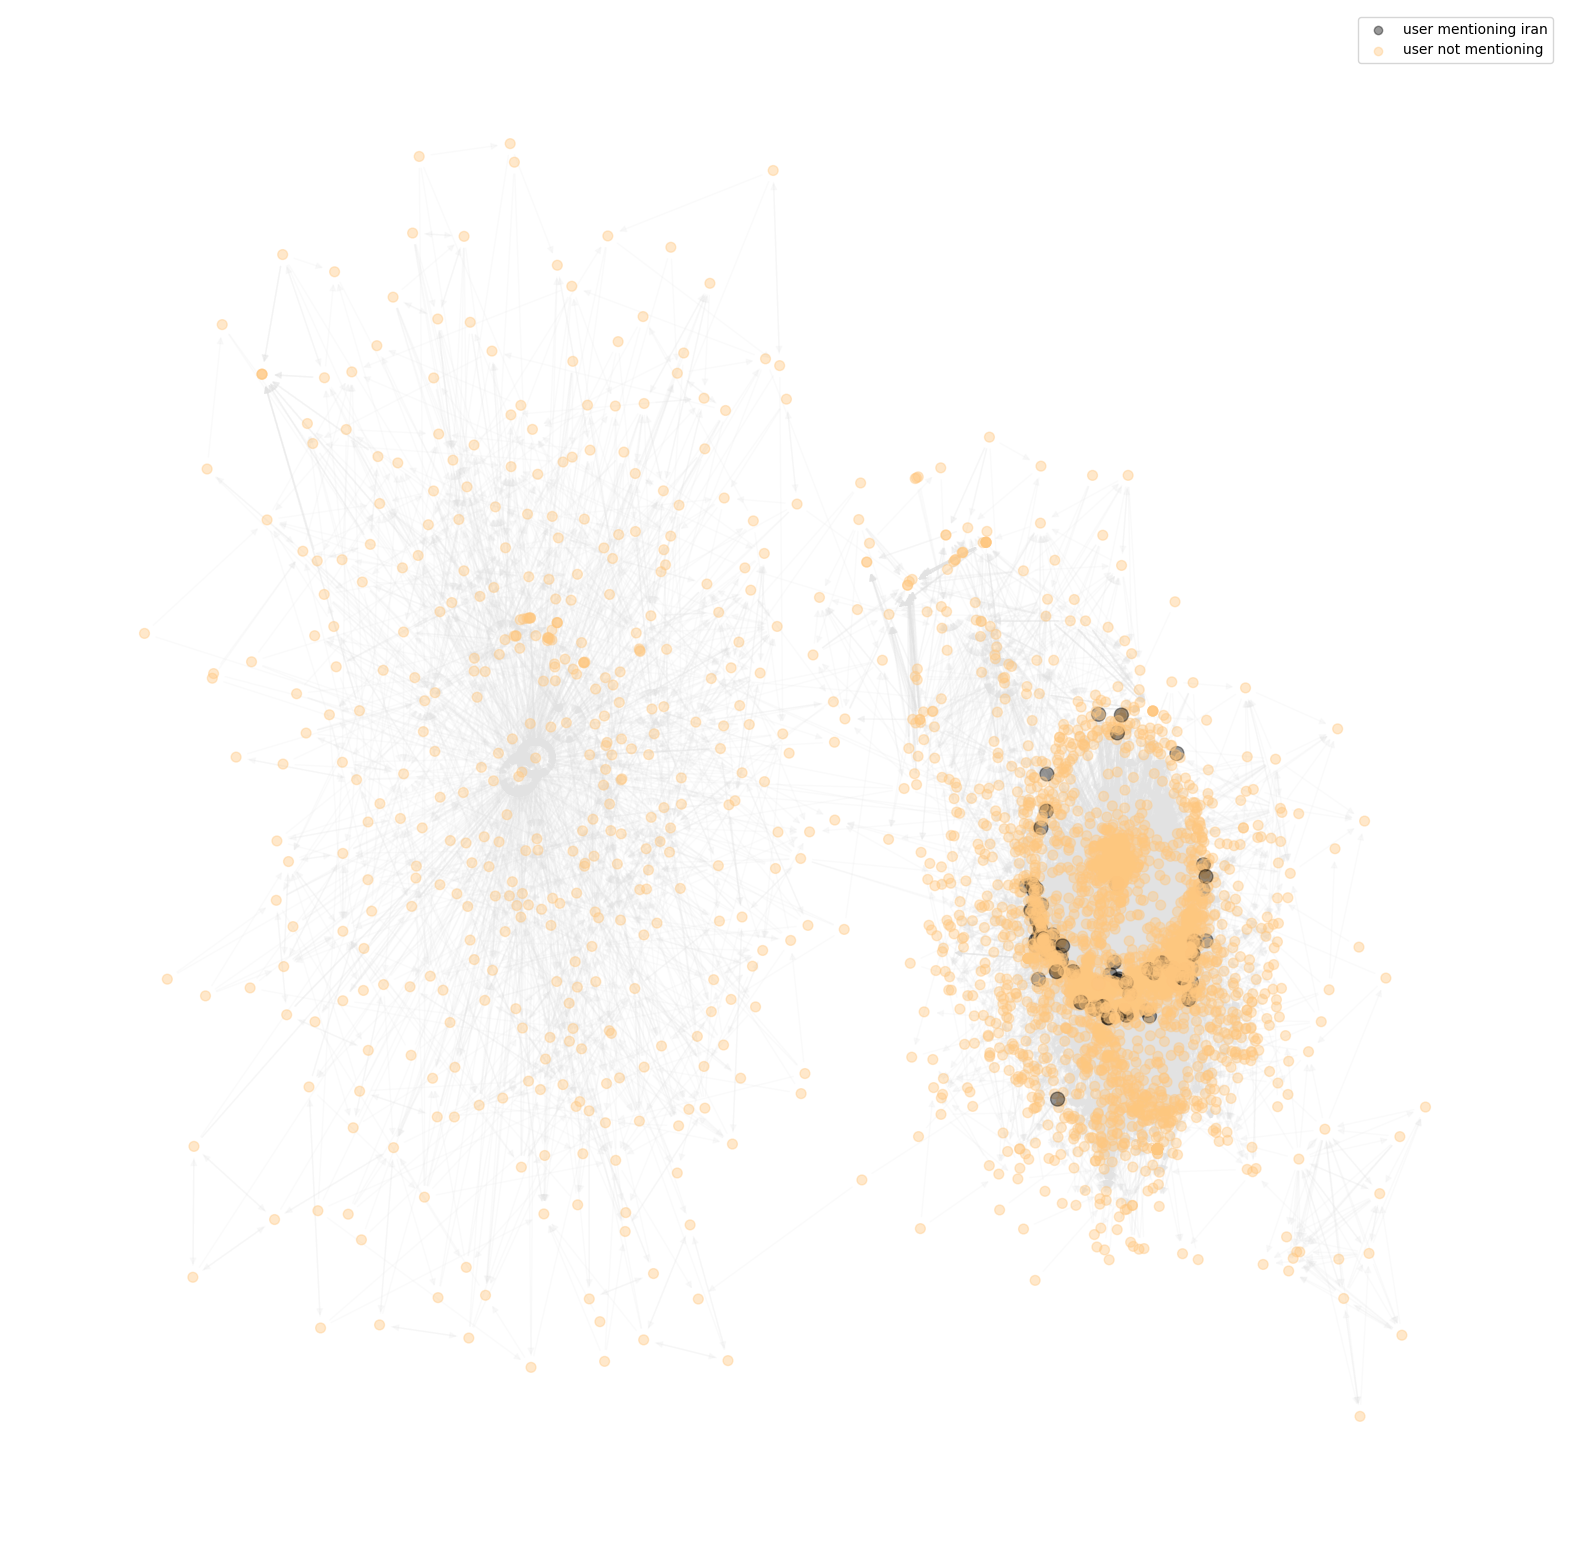

In [211]:
plot_graph(dir_mentions_graph_bots, iran_colors, 
           color_labels={'user mentioning iran':0.0, 'user not mentioning' : 1.0},
           filename='iran-users-dir-graph.png',
           alpha_edges=0.15, alpha_nodes=0.4, node_size=iran_size)

In [201]:
worldcup_community_subgraph = dir_mentions_graph_bots.subgraph(list(c[0]))

In [208]:
world_cub_iran_colors = [float(not node in df_iran.id.tolist()) for node in worldcup_community_subgraph]

In [207]:
Counter(world_cub_iran_colors)

Counter({1.0: 2142, 0.0: 82})

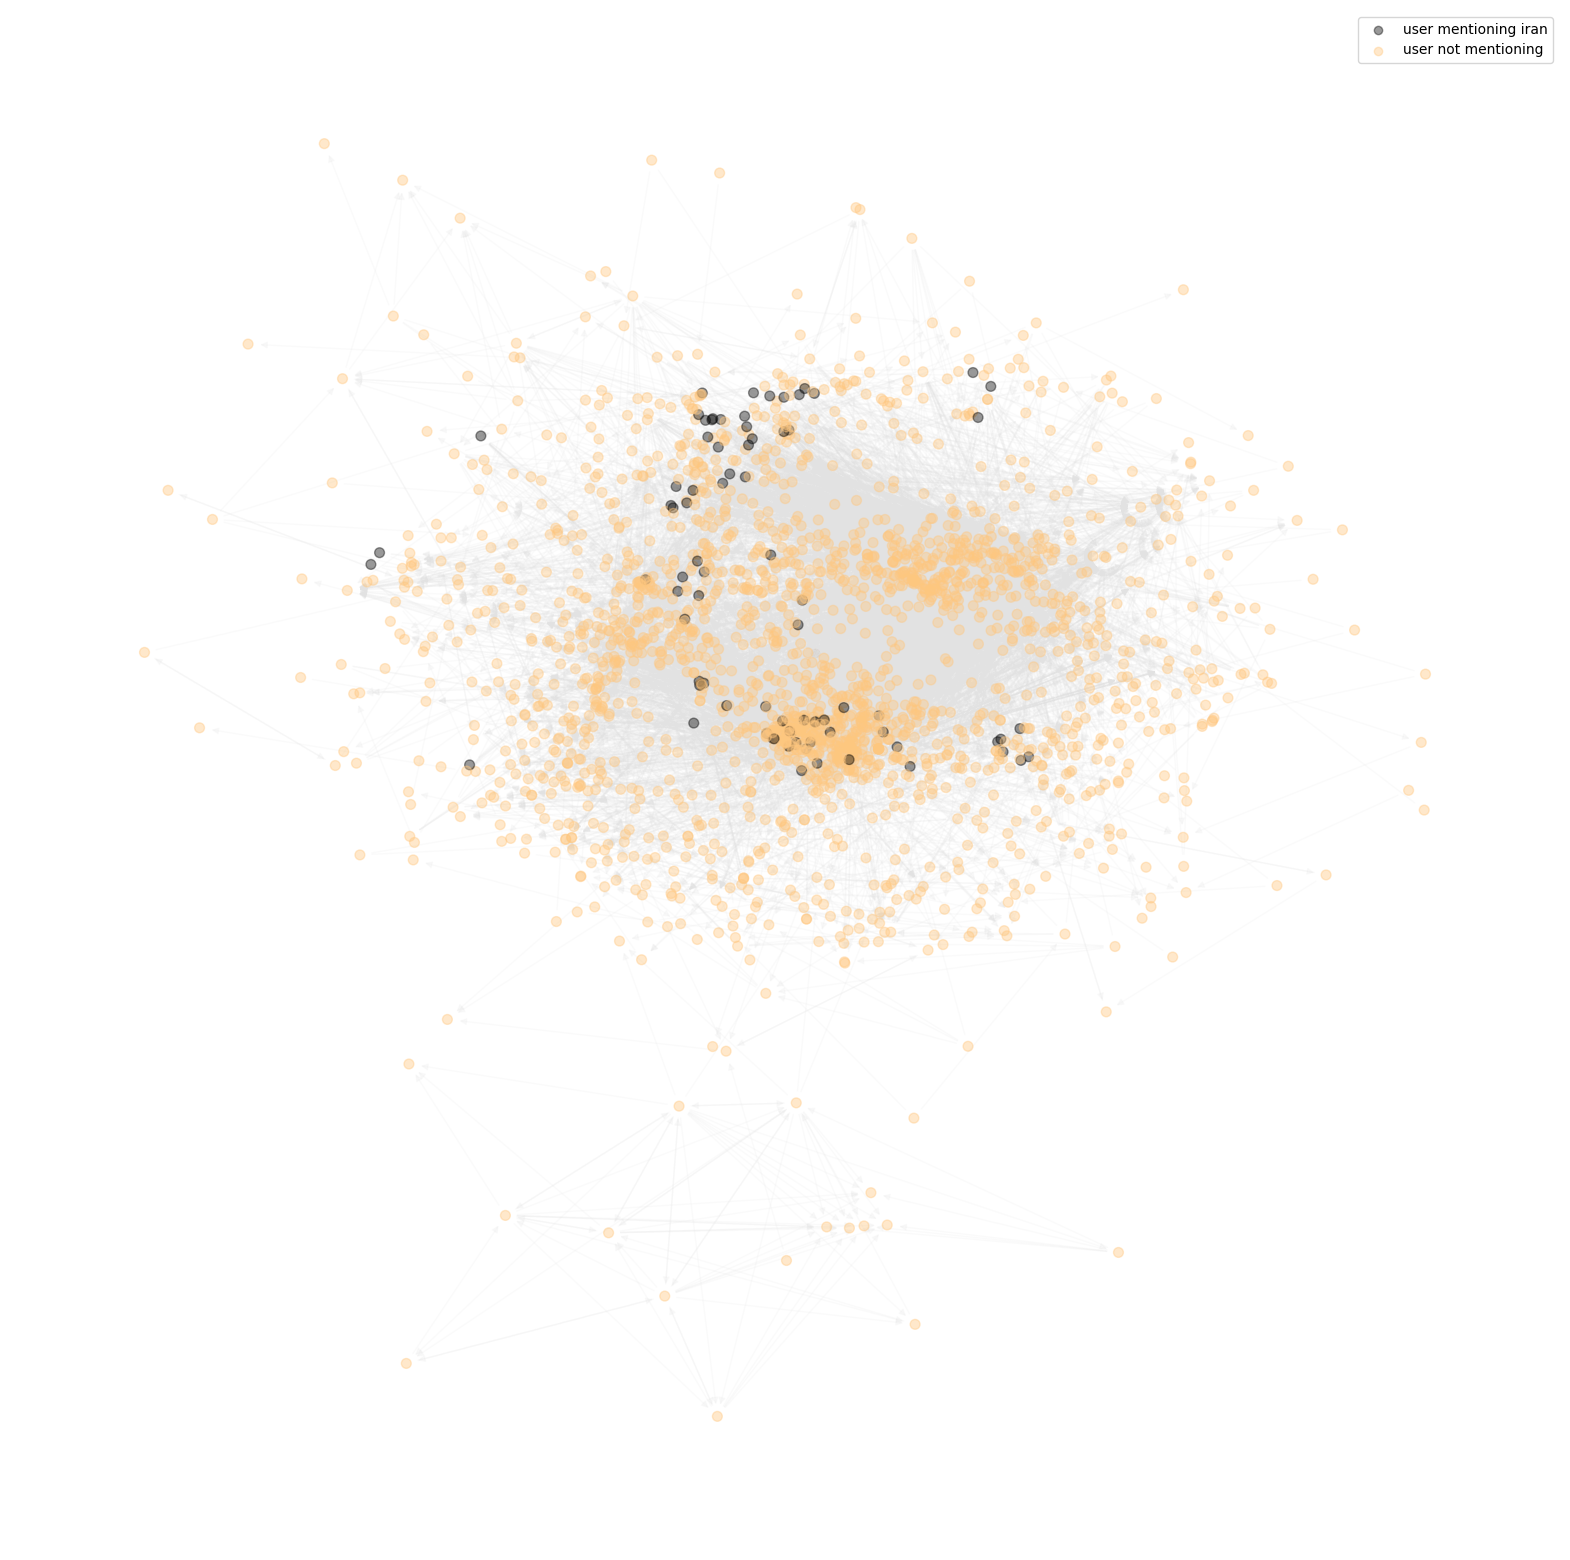

In [210]:
plot_graph(worldcup_community_subgraph, world_cub_iran_colors,
           color_labels={'user mentioning iran':0.0, 'user not mentioning' : 1.0},
           filename='iran-users-worldcup-community-subgraph.png',
           alpha_edges=0.15, alpha_nodes=0.4)

#### Subgraph with only iran users and their graph neighbours

In [70]:
iran_subgraph = dir_mentions_graph_bots.subgraph(df_iran.id)

In [71]:
# collectiong subgraph nodes
extended_subgraph_nodes = []

for node in iran_subgraph.nodes:
    neighbors = dir_mentions_graph_bots.neighbors(node)
    extended_subgraph_nodes.extend(neighbors)

In [72]:
iran_subgraph_extended = dir_mentions_graph_bots.subgraph(set(extended_subgraph_nodes).union(set(iran_subgraph.nodes)))

In [73]:
iran_subgraph_colors = [int(not node in iran_subgraph.nodes) for node in iran_subgraph_extended.nodes]

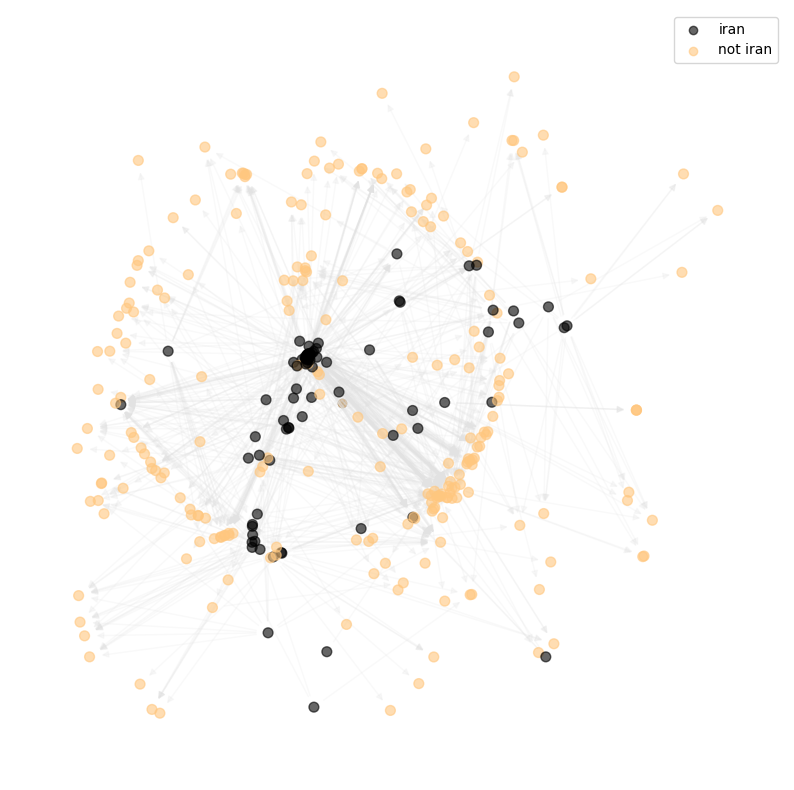

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [84]:
plot_graph(iran_subgraph_extended, iran_subgraph_colors, 
           color_labels={'iran': 0., 'not iran': 1.}, 
           alpha_edges=0.2)

plt.figure(figsize=(10, 10))